   # Homework 3

### Question 1

#### Part (a)

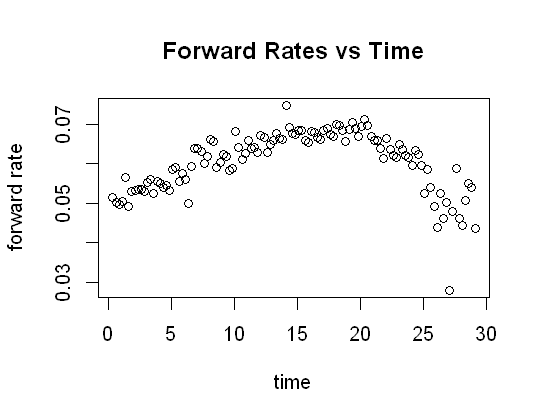

In [4]:
options(repr.plot.width=4.5, repr.plot.height=3.5)
fwd_rates = read.csv("forward_rates.csv")
plot(fwd_rates,xlab = "time", ylab = "forward rate",main = "Forward Rates vs Time")

In [6]:
x = fwd_rates$time
y = fwd_rates$rate

#### Part (b)

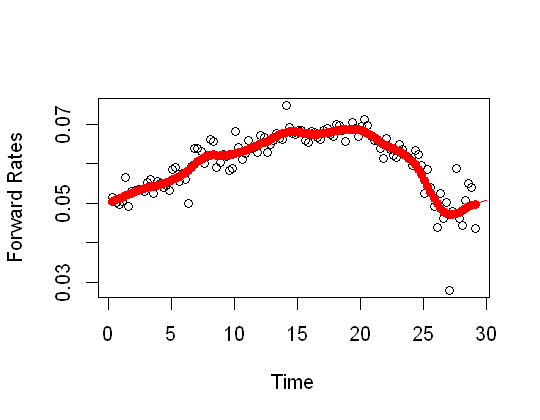

In [31]:
spl = smooth.spline(x,y)
x.grid = seq(from=0, to=30, length.out=500)
plot(x,y,xlab="Time",ylab="Forward Rates")
lines(x.grid, predict(spl, x.grid)$y, col='red', lwd=1)
points(spl$x, spl$y, col='red', pch=19)
#curve(true.curve(x),col="grey",add=TRUE)

Above performs the spline based smoothing in R with lambda corresponding to the cross-validation. The fitted curve looks reasonably smooth compared to the noisy input data points.

#### Part (c) 
The smoothing spline based regression function is a collection of piecewise cubic equations, each applicable between two knots of the spline. Which means the regression function is polynomial and the definite integration can be broken out into integrals applicable to each piecewise cubic function. We have closed form solutions for integrating polynomial functions and thus integration of splines is an exact calculation. 

Amount of computation to perform this integration is to the order of the number of knots in the spline which would be significantly faster compared to numerical integration for kernel regression in a grid of points.

### Question 2

In [33]:
bike_train = read.csv("bike_train.csv")
bike_test = read.csv("bike_test.csv")

#### Part (a)

In [158]:
rental.lm = lm(rentals ~ temp+humidity+windspeed + dayofyear + as.factor(dayofweek) +as.factor(workday)+
               as.factor(weathertype),data = bike_train)
#Factor of 1.6 to account for Y-o-Y growth as provided in question
lm.predictions = 1.6*predict.lm(rental.lm,newdata = bike_test)
MSE = sum((lm.predictions-bike_test$rentals)^2)/(nrow(bike_test))
print("The MSE of linear regression model is:")
print(MSE)

[1] "The MSE of linear regression model is:"
[1] 1271219


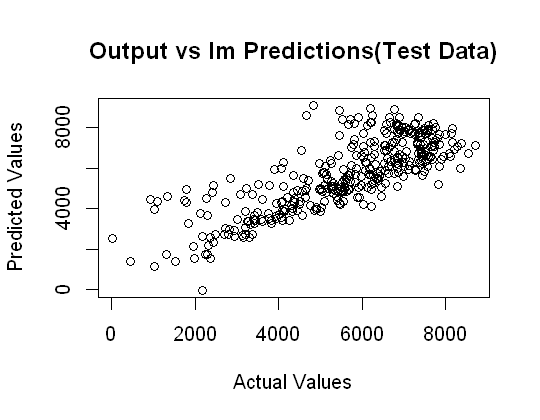

In [156]:
plot(bike_test$rentals,lm.predictions,xlab = "Actual Values", ylab = "Predicted Values",
     main = "Output vs lm Predictions(Test Data)")

#### Part (b)

[1] "The MSE of GAM model is:"
[1] 1006646


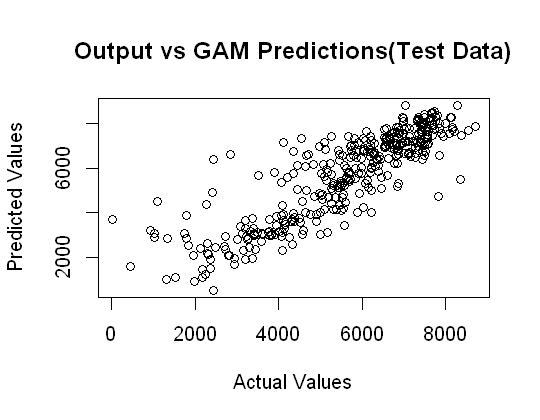

In [157]:
library(mgcv)
rental.gam = gam(rentals ~s(temp) + s(humidity) + s(windspeed) + weathertype + dayofweek + s(dayofyear)+
                 workday, data=bike_train)
gam.predictions = 1.6*predict(rental.gam,newdata = bike_test)
MSE = sum((gam.predictions-bike_test$rentals)^2)/(nrow(bike_test))
print("The MSE of GAM model is:")
print(MSE)
plot(bike_test$rentals,gam.predictions,xlab = "Actual Values", ylab = "Predicted Values",
     main = "Output vs GAM Predictions(Test Data)")

#### Part (c)

Below plots the function for each of the covariates. I can observe significant non-linearity for the covariates temp, humidity and dayofyear that a linear model would be unable to capture. 

Interpretation from below plots can be the fact that the amount of rentals are low during extreme values of temp and humidity, which is an expected behavior supported by the data. We expect more bike rentals when the weather is pleasant and less rentals when the temp or humidity is too high or too low.

I think the day of the year can have some season based correlation with average temperature, but apart from that we can see that during days of the year when temperature is too low or too high, the amount of bike rentals take a dip and are high during days when the weather remains pleasant for a bike ride.

There is a near-monotone relation with wind speed, which also is interpretable. As the wind speed increases the amount of bike rentals go down, which can be explained based on the difficulty of riding a bike during very windy conditions.

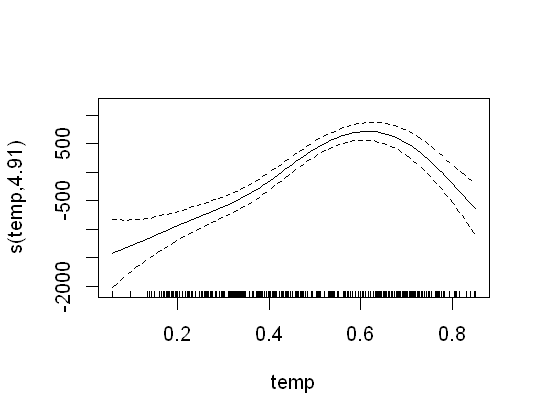

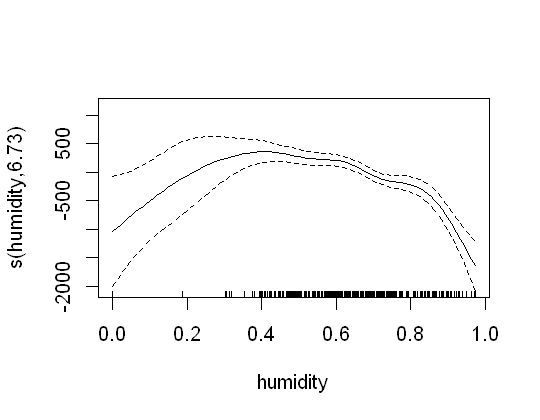

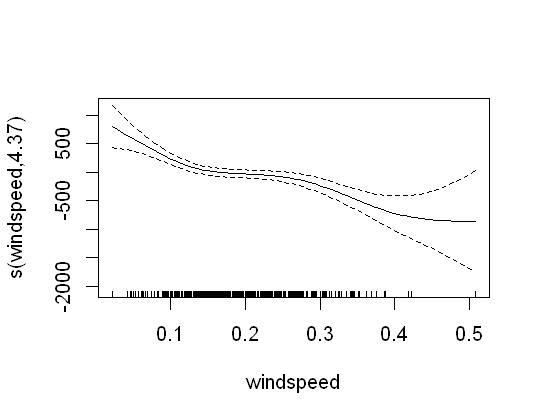

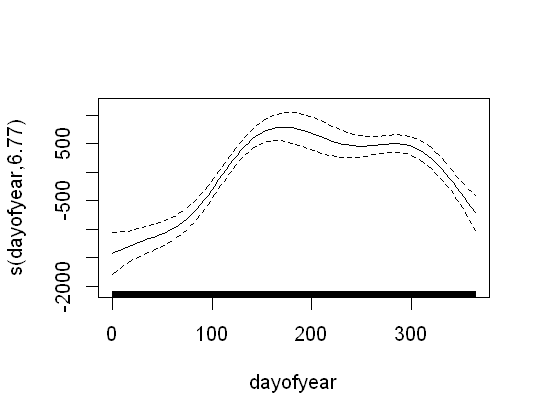

In [142]:
plot(rental.gam)

#### Part (d)

In [275]:
calc_real_loss = function(true,guess){
        residuals = true-guess
        real_loss = (sum(5*residuals[residuals>0])-sum(residuals[residuals<0]))/length(true)
    return(real_loss)
    }

In [280]:
lm.real_loss = calc_real_loss(bike_test$rentals,lm.predictions)
print("Real Loss for Linear Regression Predictions")
print(lm.real_loss)

gam.real_loss = calc_real_loss(bike_test$rentals,gam.predictions)
print("Real Loss for spline based GAM Predictions")
print(gam.real_loss)

[1] "Real Loss for Linear Regression Predictions"
[1] 2355.478
[1] "Real Loss for GAM Predictions"
[1] 2085.24


#### Part (e)

In [285]:
residuals.lm = bike_test$rentals - lm.predictions
lm.adj = quantile(residuals.lm,5/6)
lm.predictions_adj = lm.predictions + lm.adj

residuals.gam = bike_test$rentals - gam.predictions
gam.adj = quantile(residuals.gam,5/6)
gam.predictions_adj = gam.predictions + as.numeric(gam.adj)

In [286]:
lm.real_loss_adj = calc_real_loss(bike_test$rentals,lm.predictions_adj)
print(lm.real_loss_adj)

gam.real_loss_adj = calc_real_loss(bike_test$rentals,gam.predictions_adj)
print(gam.real_loss_adj)

[1] 1401.653
[1] 1368.198


The real loss after the adjustment based on residual quantile has improved significantly. The Additive model continues to perform better than the linear model in terms of real loss, both before and after adjustment. 

Based on the asymmetric loss function score, the spline based GAM model performs better compared to the linear model and we can better interpret and capture non-linearity associated with the predictor variables. So I would choose the spline based additive model as the final estimator.

### Question 3

#### Part (a)
We want to choose prediction function $\hat f (X)$ such that expected prediction error (EPE) is minimized, where

$EPE = \mathbb{E}(\mathcal{L}(Y, f (X)))$

Thus, $\hat f(x) = \text{argmin}_{g = 0,1} \sum_{k=0}^1 \mathcal{L}(k,g)\mathbb{P}(Y=k|X=x)$

$=\text{argmin}_{g = 0,1} \mathcal{L}(0,g)\mathbb{P}(Y=0|X=x)+ \mathcal{L}(1,g)\mathbb{P}(Y=1|X=x)$

If $g=1$, then $\mathcal{L}(Y(x),1) = \mathcal{L}(0,1)\mathbb{P}(Y=0|X=x)$, and if $g=0$, then $\mathcal{L}(Y(x),0) = \mathcal{L}(1,0)\mathbb{P}(Y=1|X=x)$.

Now, $g=0$ will be the chosen guess if $\mathcal{L}(Y(x),0) < \mathcal{L}(Y(x),1) \implies 
L_{10}\mathbb{P}(Y=1|X=x) < L_{01}\mathbb{P}(Y=0|X=x)$

$\implies L_{10}\mathbb{P}(Y=1|X=x) < L_{01}(1-\mathbb{P}(Y=1|X=x))$


$\implies \mathbb{P}(Y=1|X=x) < \frac{L_{01}}{L_{10}+L_{01}}$

Thus, we have $\hat f(x) = \mathbb{1}_{\mathbb{P}(Y=1|X=x) \geq \frac{L_{01}}{L_{10}+L_{01}}}
=\mathbb{1}_{\mathbb{P}(Y=0|X=x) \leq \frac{L_{10}}{L_{10}+L_{01}}}$

#### Part (b)
If $L_{10} > L_{01}$, then false negatives have more penalty and from our best possible classification function calculated above, the criteria for guessing a value of 0 is, $\mathbb{P}(Y=0|X=x) > \frac{L_{10}}{L_{10}+L_{01}}$. Which means $\mathbb{P}(Y=0|X=x)$ needs to be similarly large for the classification function to guess a class of label 0. 

This makes sense because the larger the penalty on false negatives, the more we would like to be sure about the true probability of a data being part of label 0 class. Thus the cut-off probability for classifying a data point as label 0 increases.

#### Part (c)
For classifier using logistic regression, the classification rule under new loss will classify to label 1 if 

$\mathbb{P}(Y=1|X=x) \geq \frac{L_{01}}{L_{10}+L_{01}} \implies \frac{\exp(x^T\hat\beta)}{1+\exp(x^T\hat\beta)} \geq \frac{L_{01}}{L_{10}+L_{01}} \implies \exp(x^T\hat \beta) \geq \frac{L_{01}}{L_{10}} 
\implies x^T \hat \beta \geq \log(\frac{L_{01}}{L_{10}})$

Thus, 

\begin{align}
\hat f(x) = & 1 &\text{if,   } &     x^T\hat \beta  \geq \log\left(\frac{L_{01}}{L_{10}}\right)\\
  = & 0 & otherwise\\
\end{align}

If $L_{10} > L_{01}$, then the decision boundary will have a parallel shift and will include the origin in the region of class label 1 as $\log\left(\frac{L_{01}}{L_{10}}\right) < 0$